# This notebook consists of a quick way of integrating the PF likelihood computation as a pints.ProblemLogLikelihood function and trying some samplers and optimisers

# Importing libraries and setting plot parameters

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pints
import pints.toy as toy
import pints.plot
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import pints.plot
from multiprocessing import Pool
from PFClasses import SimpleModel, ParticleFilter, Kalman, Event, StochasticModelTauLeaping

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 5.9/2, 2.43
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 3
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"



# Some quick extensions of the pints.ProblemLogLikelihood for stochastic PF

In [11]:
class PF_LL_Stochastic(pints.ProblemLogLikelihood):
    def __init__(self, measurements, N):
        self.measurements = measurements
        self.x0 = measurements[0]
        self._n_parameters = 3
        self.N = N
    
    def __call__(self, x):
        b, k, r = x
        
        birth = Event(
            rate_calculator=lambda x: max(0, x[0] * b * (1 - float(x[0])/k)),
            change_function=lambda x: [x[0] + 1]
            )
        
        model = StochasticModelTauLeaping(x_0=np.array([100.]), events=[birth], step_size=1, R=np.array([[r]]))
        
        pf = ParticleFilter(model=model, N=self.N, measurements=self.measurements,
                           prior_cov_matrix=np.array([[r]]))
        
        return pf.run()[2]
    
class PF_LL_Stochastic_Simple(pints.ProblemLogLikelihood):
    def __init__(self, measurements, N):
        self.measurements = measurements
        self.x0 = measurements[0]
        self._n_parameters = 1
        self.N = N
    
    def __call__(self, k):
        b, k, r = .01, k, 50
        
        birth = Event(
            rate_calculator=lambda x: max(0, x[0] * b * (1 - float(x[0])/k)),
            change_function=lambda x: [x[0] + 1]
            )
        
        model = StochasticModelTauLeaping(x_0=np.array([100.]), events=[birth], step_size=1, R=np.array([[r]]))
        
        pf = ParticleFilter(model=model, N=self.N, measurements=self.measurements,
                           prior_cov_matrix=np.array([[50.]]))
        
        return pf.run()[2]

# Some quick extensions of the pints.ProblemLogLikelihood for Linear Gaussian 1D PF

In [3]:
class KF_LL_1D(pints.ProblemLogLikelihood):
    def __init__(self, measurements):
        self.measurements = measurements
        self.x0 = measurements[0]
        self._n_parameters = 4
    
    def __call__(self, x):
        F, H, Q, R = x
        model = SimpleModel(self.x0, np.array([[F]]), np.array([[H]]), np.array([[Q]]), np.array([[R]]))
        kf = Kalman(model, self.measurements)
        return kf.run()[2]
    
class PF_LL_1D(pints.ProblemLogLikelihood):
    def __init__(self, measurements):
        self.measurements = measurements
        self.x0 = measurements[0]
        self._n_parameters = 4
    
    def __call__(self, x):
        F, H, Q, R = x
        model = SimpleModel(self.x0, np.array([[F]]), np.array([[H]]), np.array([[Q]]), np.array([[R]]))
        pf = ParticleFilter(model, N=100, measurements=self.measurements, prior_cov_matrix=model.Q)
        return pf.run()[2]
    
class PF_LL_1D_Simple(pints.ProblemLogLikelihood):
    def __init__(self, measurements):
        self.measurements = measurements
        self.x0 = measurements[0]
        self._n_parameters = 1
    
    def __call__(self, F):
        model = SimpleModel(self.x0, np.array([[F]]), np.array([[1.]]), np.array([[1.]]), np.array([[1.]]))
        pf = ParticleFilter(model, N=100, measurements=self.measurements, prior_cov_matrix=model.Q)
        return pf.run()[2]

# Simulating an 1D model

In [4]:
x_0 = np.array([0.])
F = np.array([[1.]])
H = np.array([[1.]])
Q = np.array([[1.]])
R = np.array([[1.]])

model_1D = SimpleModel(x_0, F, H, Q, R)
time_1D = 50
measurements_1D = [model_1D.measure(t) for t in range(time_1D)]

# Optimisation for 1D using KF

In [13]:
loglikelihood = KF_LL_1D(measurements_1D)
y0 = np.array([1.25, 0.75, 1.1, 0.9])
boundaries_3d = pints.RectangularBoundaries([0, 0, 0, 0], [2, 2, 2, 2])

opt = pints.OptimisationController(loglikelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

Estimated parameters:
[0.93205509 0.79819972 2.         0.77295081]


# Optimisation for 1D using PF

In [ ]:
loglikelihood = PF_LL_1D(measurements_1D)
y0 = np.array([1.25, 0.75, 1.1, 0.9])
boundaries_3d = pints.RectangularBoundaries([0, 0, 0, 0], [2, 2, 2, 2])

opt = pints.OptimisationController(loglikelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

In [ ]:
loglikelihood = PF_LL_1D_Simple(measurements_1D)
y0 = np.array([1.25])
boundaries_3d = pints.RectangularBoundaries([0], [2])

opt = pints.OptimisationController(loglikelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

# Sampler for kalman 1D

In [5]:
loglikelihood = KF_LL_1D(measurements_1D)
true_parameters = [1., 1., 1., 1.]

log_prior = pints.UniformLogPrior(
    [0, 0, 0, 0],
    [10, 10, 10, 10]
    )

log_posterior = pints.LogPosterior(loglikelihood, log_prior)

xs = [
    np.array(true_parameters) * 0.85,
    np.array(true_parameters) * 0.90,
    np.array(true_parameters) * 0.95,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.1,
    np.array(true_parameters) * 1.15,
]

mcmc = pints.MCMCController(log_posterior, len(xs), xs)
mcmc.set_max_iterations(10000)
mcmc.set_parallel(len(xs))

chains = mcmc.run()

Using Adaptive covariance MCMC
Generating 6 chains.
Running in parallel with 6 worker processess.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Accept.   Accept.   Time m:s
0     6      0         0         0         0         0         0          0:00.0
1     12     0.5       0         0         0         0         0.5        0:00.1
2     18     0.667     0         0         0.333     0.333     0.333      0:00.1
3     24     0.5       0         0         0.25      0.5       0.5        0:00.1
20    126    0.524     0.333     0.381     0.333     0.286     0.524      0:00.2
40    246    0.415     0.317     0.39      0.366     0.366     0.439      0:00.4
60    366    0.328     0.311     0.377     0.361     0.393     0.426      0:00.6
80    486    0.345679  0.296     0.42      0.321     0.358     0.457      0:00.8
100   606    0.327     0.317     0.406     0.337     0.337     0.436      0:00.9
120   726    0.273     0.298     0.372     0.355     0.347     0.397      0:01.1
140   846  

1920  11526  0.194     0.206     0.223     0.218     0.207     0.216      0:17.4
1940  11646  0.193     0.207     0.223     0.218     0.207     0.216      0:17.7
1960  11766  0.193     0.207     0.223     0.22      0.207     0.215      0:17.9
1980  11886  0.192     0.205     0.223     0.22      0.208     0.216      0:18.2
2000  12006  0.191904  0.204     0.22      0.219     0.209     0.216      0:18.5
2020  12126  0.191     0.204     0.222     0.218     0.209     0.215      0:18.7
2040  12246  0.193     0.203     0.22195   0.219     0.209     0.214      0:18.9
2060  12366  0.193     0.202329  0.221     0.218     0.209     0.213      0:19.1
2080  12486  0.194     0.205     0.222     0.217     0.209     0.211      0:19.4
2100  12606  0.195     0.204     0.22      0.218     0.209     0.209      0:19.6
2120  12726  0.195     0.206     0.221     0.22      0.211     0.208      0:19.8
2140  12846  0.194     0.206     0.22      0.22      0.212     0.209      0:20.1
2160  12966  0.194     0.205

3960  23766  0.22      0.217     0.222     0.22      0.222     0.224      0:38.2
3980  23886  0.221     0.217     0.222306  0.22      0.222306  0.225      0:38.5
4000  24006  0.220195  0.217     0.222     0.22      0.223     0.225      0:38.9
4020  24126  0.22      0.218     0.222     0.22      0.223     0.224      0:39.1
4040  24246  0.221     0.218     0.221     0.219     0.223     0.224      0:39.4
4060  24366  0.222     0.218     0.221374  0.218     0.224     0.225      0:39.7
4080  24486  0.222     0.217     0.222     0.219     0.224     0.225      0:40.2
4100  24606  0.222     0.217     0.221     0.218     0.224     0.225      0:40.6
4120  24726  0.221     0.216     0.222     0.218     0.223     0.226      0:41.0
4140  24846  0.222     0.217     0.223376  0.218     0.225     0.226      0:41.3
4160  24966  0.222     0.217     0.223504  0.218     0.225     0.226      0:41.6
4180  25086  0.222     0.217     0.224     0.218     0.226     0.22674    0:41.8
4200  25206  0.22209   0.218

6000  36006  0.209     0.216     0.217     0.226     0.221     0.223      0:58.2
6020  36126  0.209     0.216     0.217     0.226     0.221     0.223717   0:58.4
6040  36246  0.208     0.216     0.217     0.226     0.22      0.224      0:58.5
6060  36366  0.209     0.216136  0.218     0.226     0.22      0.224      0:58.7
6080  36486  0.208     0.215754  0.218     0.226     0.22      0.224      0:58.8
6100  36606  0.208     0.216     0.218     0.226     0.22      0.225209   0:59.0
6120  36726  0.207     0.215     0.218     0.226     0.22      0.225      0:59.2
6140  36846  0.207     0.215     0.218     0.225859  0.219     0.225859   0:59.3
6160  36966  0.206     0.215     0.218     0.226     0.219     0.226      0:59.5
6180  37086  0.206     0.214852  0.218     0.226     0.219382  0.226177   0:59.6
6200  37206  0.205     0.214     0.218     0.226     0.219642  0.226      0:59.8
6220  37326  0.205     0.214     0.218     0.226     0.22      0.226      0:59.9
6240  37446  0.205     0.214

8040  48246  0.217     0.22      0.221     0.225     0.224     0.228      1:17.4
8060  48366  0.217     0.22      0.222     0.226     0.223     0.228      1:17.6
8080  48486  0.216     0.219651  0.221     0.226     0.223     0.228      1:17.8
8100  48606  0.217     0.22      0.221701  0.227     0.224     0.228      1:17.9
8120  48726  0.217     0.22      0.222017  0.227     0.224     0.227      1:18.1
8140  48846  0.217     0.22      0.222     0.227     0.224     0.227      1:18.3
8160  48966  0.217     0.219826  0.222     0.227     0.223502  0.228      1:18.5
8180  49086  0.217     0.22      0.222     0.227     0.223     0.228      1:18.6
8200  49206  0.216559  0.219     0.221     0.226     0.224     0.227899   1:18.8
8220  49326  0.216397  0.219     0.221     0.226     0.223     0.228      1:19.0
8240  49446  0.217     0.219     0.221     0.226     0.223     0.228      1:19.2
8260  49566  0.217     0.218     0.221886  0.226     0.223     0.227      1:19.3
8280  49686  0.217     0.218

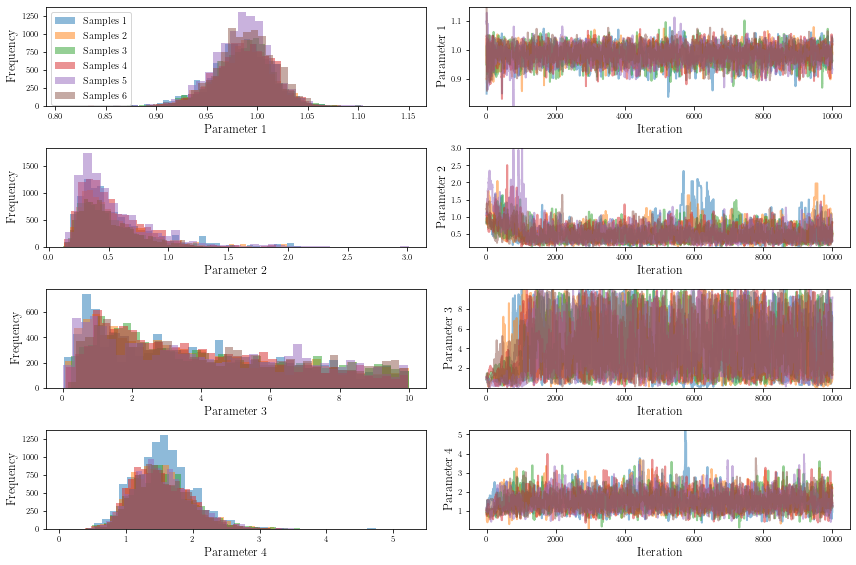

In [7]:
pints.plot.trace(chains)
plt.savefig("kalman_sampler.pdf", bbox_inches='tight')

# sampler PF

In [ ]:
loglikelihood = PF_LL_1D(measurements_1D)
true_parameters = [1., 1., 1., 1.]

log_prior = pints.UniformLogPrior(
    [0, 0, 0, 0],
    [10, 10, 10, 10]
    )

log_posterior = pints.LogPosterior(loglikelihood, log_prior)

number_of_samplers = 10

xs = [np.array(true_parameters) * x for x in np.linspace(0.5, 1.5, number_of_samplers)]

mcmc = pints.MCMCController(log_posterior, len(xs), xs)
mcmc.set_max_iterations(10000)
mcmc.set_parallel(len(xs))

chains = mcmc.run()

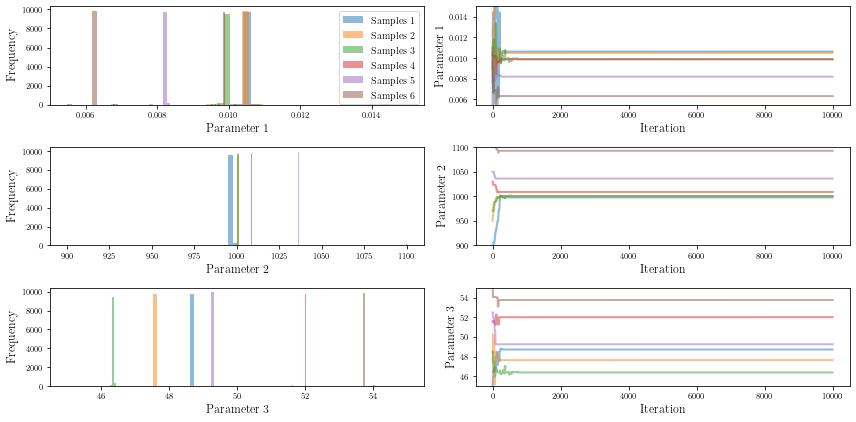

In [20]:
import pickle
with open(f'RESULT_pf_stochastic.pickle', 'rb') as handle:
    chains = pickle.load(handle)
pints.plot.trace(chains)
plt.savefig("pf_sampler.pdf", bbox_inches='tight')

(<Figure size 864x864 with 16 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128495d90>,
       dtype=object))

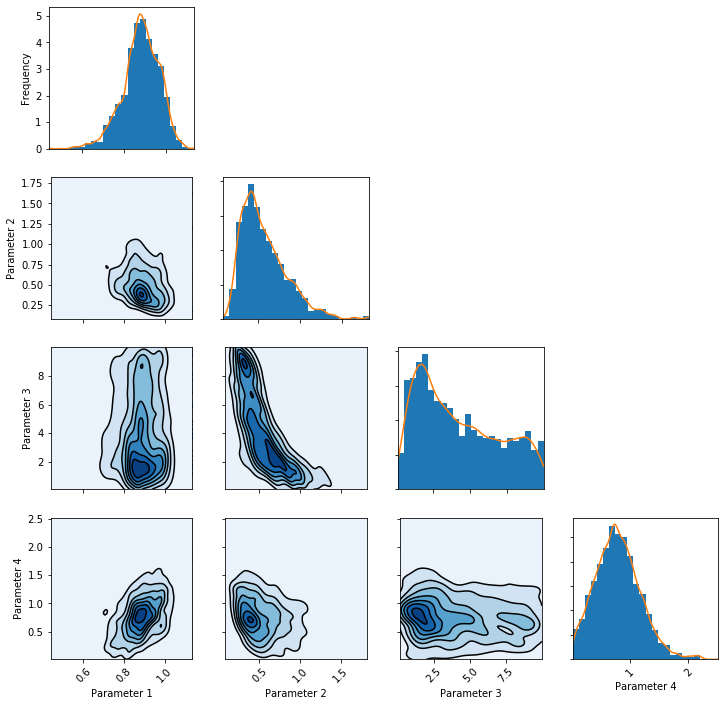

In [10]:
pints.plot.pairwise(chains[0], kde=True)

In [6]:
loglikelihood = PF_LL_1D(measurements_1D)
true_parameters = [1., 1., 1., 1.]

log_prior = pints.UniformLogPrior(
    [0, 0, 0, 0],
    [2, 2, 2, 2]
    )

log_posterior = pints.LogPosterior(loglikelihood, log_prior)

xs = [
    np.array(true_parameters) * 0.85,
    np.array(true_parameters) * 0.90,
    np.array(true_parameters) * 0.95,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.1,
    np.array(true_parameters) * 1.15,
]

mcmc = pints.MCMCController(log_posterior, len(xs), xs)
mcmc.set_max_iterations(1000)
mcmc.set_parallel(len(xs))

chains = mcmc.run()

Using Adaptive covariance MCMC
Generating 6 chains.
Running in parallel with 6 worker processess.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Accept.   Accept.   Time m:s
0     6      0         0         0         0         0         0          0:00.2
1     12     0.5       0         0.5       0         0.5       0.5        0:00.4
2     18     0.333     0         0.333     0         0.667     0.333      0:00.5
3     24     0.5       0.25      0.5       0.25      0.75      0.5        0:00.7
20    126    0.381     0.0952    0.476     0.19      0.286     0.333      0:03.5
40    246    0.244     0.0732    0.293     0.195122  0.317     0.293      0:07.6
60    366    0.164     0.082     0.213     0.164     0.328     0.23       0:11.9
80    486    0.136     0.0864    0.247     0.235     0.272     0.235      0:15.5
100   606    0.109     0.0792    0.228     0.248     0.307     0.208      0:19.1
120   726    0.0992    0.0661    0.248     0.207     0.281     0.182      0:22.6
140   846  

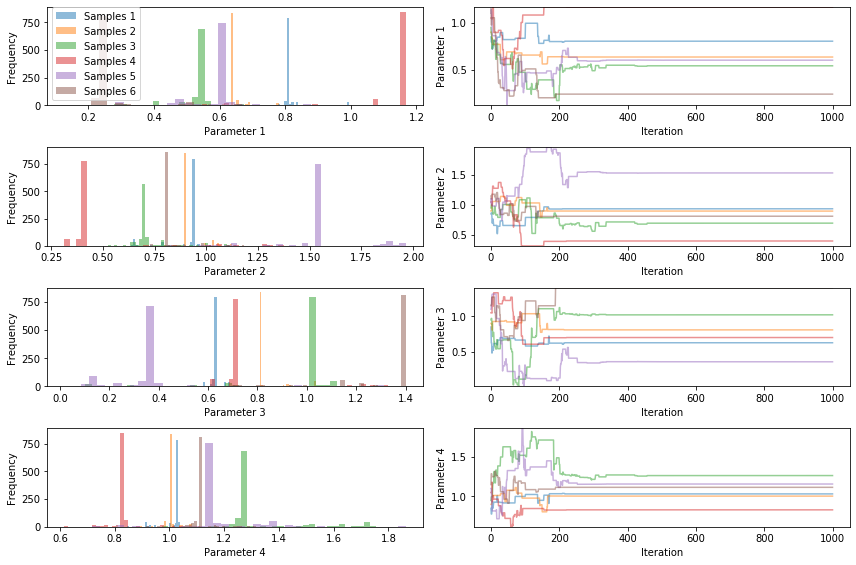

In [7]:
import pints.plot
pints.plot.trace(chains)
plt.show()

In [40]:
loglikelihood = PF_LL_1D(measurements_1D)
true_parameters = [1., 1., 1., 1.]

log_prior = pints.UniformLogPrior(
    [0, 0, 0, 0],
    [2, 2, 2, 2]
    )

log_posterior = pints.LogPosterior(loglikelihood, log_prior)

xs = [
    np.array(true_parameters) * 0.85,
    np.array(true_parameters) * 0.90,
    np.array(true_parameters) * 0.95,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.1,
    np.array(true_parameters) * 1.15,
]

mcmc = pints.MCMCController(log_posterior, len(xs), xs)
mcmc.set_max_iterations(100)
mcmc.set_parallel(len(xs))

chains = mcmc.run()

Using Adaptive covariance MCMC
Generating 6 chains.
Running in parallel with 6 worker processess.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Accept.   Accept.   Time m:s
0     6      0         0         0         0         0         0          0:01.5
1     12     0.5       0         0.5       0         0.5       0          0:03.0
2     18     0.667     0         0.333     0         0.667     0.333      0:04.4
3     24     0.5       0         0.25      0         0.5       0.25       0:06.1
20    126    0.238     0.143     0.286     0.333     0.238     0.143      0:33.8
40    246    0.22      0.146     0.317     0.341     0.171     0.171      1:05.7
60    366    0.147541  0.18      0.262     0.295082  0.23      0.18       1:37.8
80    486    0.16      0.198     0.222     0.247     0.185     0.16       2:13.8
100   600    0.13      0.19      0.19      0.25      0.16      0.15       2:45.0
Halting: Maximum number of iterations (100) reached.


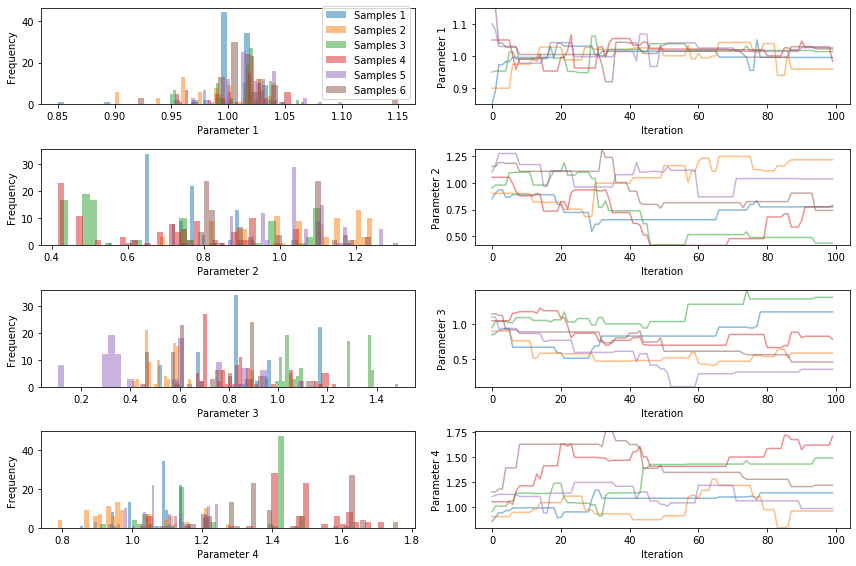

In [41]:
import pints.plot
pints.plot.trace(chains)
plt.show()

In [63]:
loglikelihood = PF_LL_1D_Simple(measurements_1D)
true_parameters = [1.]

log_prior = pints.UniformLogPrior(
    [0], [2]
    )

log_posterior = pints.LogPosterior(loglikelihood, log_prior)

xs = [
    np.array(true_parameters) * 0.85,
    np.array(true_parameters) * 0.90,
    np.array(true_parameters) * 0.95,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.1,
    np.array(true_parameters) * 1.15,
]

mcmc = pints.MCMCController(log_posterior, len(xs), xs)
mcmc.set_max_iterations(100)
mcmc.set_parallel(len(xs))

chains = mcmc.run()

Using Adaptive covariance MCMC
Generating 6 chains.
Running in parallel with 6 worker processess.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Accept.   Accept.   Time m:s
0     6      0         0         0         0         0         0          0:01.5
1     12     0         0         0         0         0.5       0.5        0:02.9
2     18     0.333     0.333     0         0.333     0.333     0.333      0:04.4
3     24     0.5       0.25      0         0.25      0.25      0.5        0:05.8
20    126    0.238     0.238     0.0476    0.143     0.19      0.333      0:36.5
40    246    0.122     0.195122  0.0976    0.22      0.146     0.244      1:11.5
60    366    0.115     0.147541  0.082     0.18      0.147541  0.213      1:50.1
80    486    0.123     0.123     0.0741    0.16      0.136     0.21       2:24.1
100   600    0.1       0.1       0.06      0.14      0.17      0.18       2:55.7
Halting: Maximum number of iterations (100) reached.


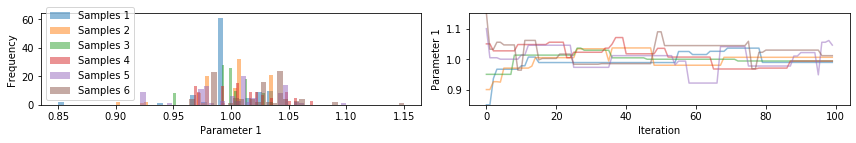

In [64]:
import pints.plot
pints.plot.trace(chains)
plt.show()

In [9]:
b = .01
K = 1000
sigma = 50
x_0 = np.array([100.])
times = range(800)

real_birth = Event(
    rate_calculator=lambda x: max(0, x[0] * b * (1 - float(x[0])/K)),
    change_function=lambda x: [x[0] + 1]
    )
model_stochastic = StochasticModelTauLeaping(x_0, events=[real_birth], step_size=1, 
                                   R=np.array([[sigma]]))

measurements_stochastic = [model_stochastic.measure(t) for t in times]

# Samplers

In [16]:
loglikelihood = PF_LL_Stochastic(measurements_stochastic, N=100)
true_parameters = [b, K, sigma]

log_prior = pints.UniformLogPrior(
    [0.005, 800, 30],
    [0.015, 1200, 70]
    )

log_posterior = pints.LogPosterior(loglikelihood, log_prior)

xs = [
    np.array(true_parameters) * 0.90,
    np.array(true_parameters) * 0.95,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.1,
]


In [17]:
mcmc = pints.MCMCController(log_posterior, len(xs), xs)
mcmc.set_max_iterations(50)
mcmc.set_parallel(len(xs))

In [18]:
chains = mcmc.run()

Using Adaptive covariance MCMC
Generating 4 chains.
Running in parallel with 4 worker processess.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:07.4
1     8      0         0         0         0          0:07.4
2     12     0.333     0.333     0         0          0:14.4
3     16     0.5       0.25      0         0          0:20.8
20    84     0.19      0.19      0.0952    0.0476     1:55.3
40    164    0.244     0.195122  0.0732    0.0488     3:55.3
50    200    0.22      0.16      0.08      0.04       4:50.0
Halting: Maximum number of iterations (50) reached.


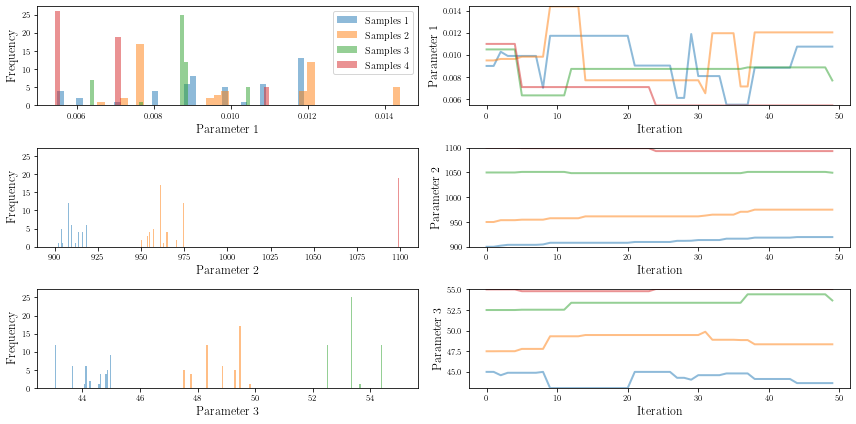

In [19]:
pints.plot.trace(chains)
plt.show()

In [48]:
loglikelihood = PF_LL_Stochastic(measurements_stochastic, N=200)
true_parameters = [b, K, sigma]

log_prior = pints.UniformLogPrior(
    [0.005, 800, 30],
    [0.015, 1200, 70]
    )

log_posterior = pints.LogPosterior(loglikelihood, log_prior)

xs = [
    np.array(true_parameters) * 0.90,
    np.array(true_parameters) * 0.95,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.1,
]

mcmc = pints.MCMCController(log_posterior, len(xs), xs)
mcmc.set_max_iterations(1000)
mcmc.set_parallel(len(xs))

In [49]:
chains = mcmc.run()

Using Adaptive covariance MCMC
Generating 4 chains.
Running in parallel with 4 worker processess.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.9
1     8      0         0         0.5       0          0:01.7
2     12     0         0         0.333     0          0:02.5
3     16     0         0         0.25      0          0:03.2
20    84     0.143     0.0476    0.238     0.0952     0:13.4
40    164    0.195122  0.0732    0.195122  0.22       0:26.7
60    244    0.18      0.147541  0.197     0.197      0:38.4
80    324    0.198     0.136     0.21      0.148      0:52.6
100   404    0.168     0.139     0.208     0.139      1:06.7
120   484    0.157     0.14      0.182     0.14       1:20.0
140   564    0.191     0.156     0.199     0.135      1:32.6
160   644    0.199     0.161     0.186     0.124      1:47.1
180   724    0.21      0.155     0.188     0.121547   2:02.1
Initial phase completed.
200   804    0.199005  

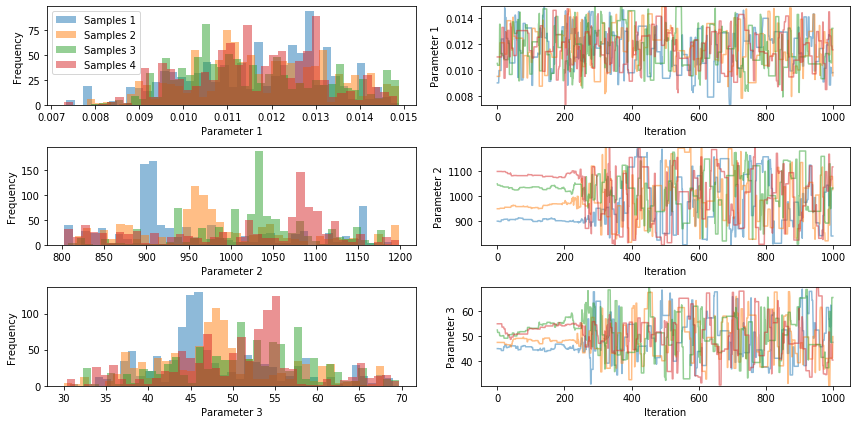

In [50]:
import pints.plot
pints.plot.trace(chains)
plt.show()

In [51]:
loglikelihood = PF_LL_Stochastic(measurements_stochastic, N=1000)
true_parameters = [b, K, sigma]

log_prior = pints.UniformLogPrior(
    [0.005, 800, 30],
    [0.015, 1200, 70]
    )

log_posterior = pints.LogPosterior(loglikelihood, log_prior)

xs = [
    np.array(true_parameters) * 0.90,
    np.array(true_parameters) * 0.95,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.1,
]

mcmc = pints.MCMCController(log_posterior, len(xs), xs)
mcmc.set_max_iterations(100)
mcmc.set_parallel(len(xs))

chains = mcmc.run()

Using Adaptive covariance MCMC
Generating 4 chains.
Running in parallel with 4 worker processess.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:04.2
1     8      0.5       0         0         0          0:08.3
2     12     0.333     0         0         0.333      0:12.3
3     16     0.5       0         0         0.5        0:16.2
20    84     0.333     0.286     0.0952    0.286      1:18.7
40    164    0.317     0.244     0.122     0.22       2:25.5
60    244    0.246     0.262     0.18      0.213      3:35.2
80    324    0.235     0.247     0.21      0.222      4:49.3
100   400    0.23      0.22      0.21      0.22       5:38.4
Halting: Maximum number of iterations (100) reached.


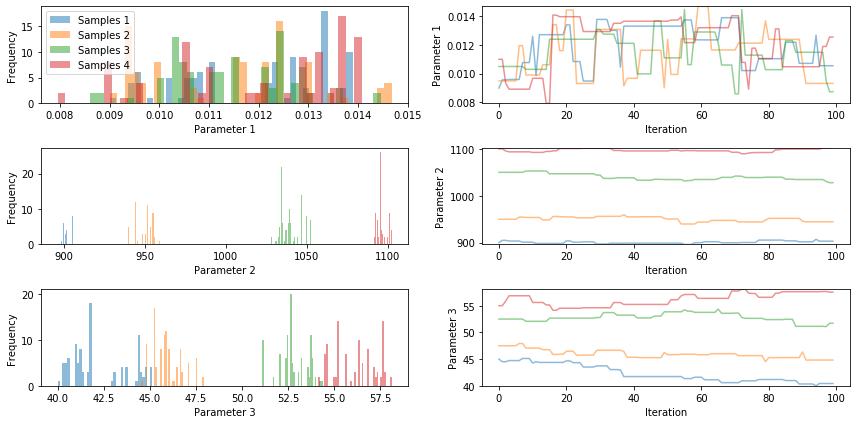

In [52]:
import pints.plot
pints.plot.trace(chains)
plt.show()

In [ ]:
loglikelihood = PF_LL_Stochastic_Simple(measurements_stochastic, N=1000)
true_parameters = [K]

log_prior = pints.UniformLogPrior(
    [500],
    [1500]
    )

log_posterior = pints.LogPosterior(loglikelihood, log_prior)

xs = [
    np.array(true_parameters) * 0.90,
    np.array(true_parameters) * 0.95,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.1,
]

mcmc = pints.MCMCController(log_posterior, len(xs), xs)
mcmc.set_max_iterations(100)
mcmc.set_parallel(len(xs))

chains = mcmc.run()

In [3]:
def show(name):
    chains = pickle.load(open(name, "rb"))
    pints.plot.trace(chains)
    plt.show()

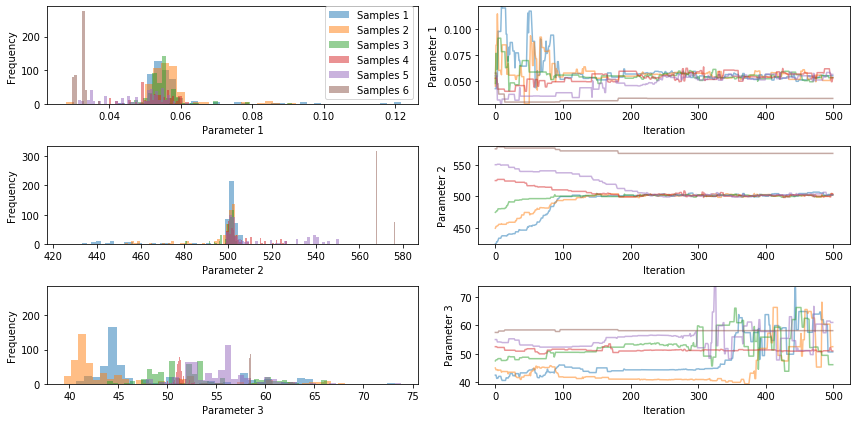

In [4]:
show('sampling1583958779_b0.05_k500_sigma50_x_010.0_time200_N500_iters500.p')

In [4]:
chains = pickle.load(open("sampling1583942135.p", "rb"))

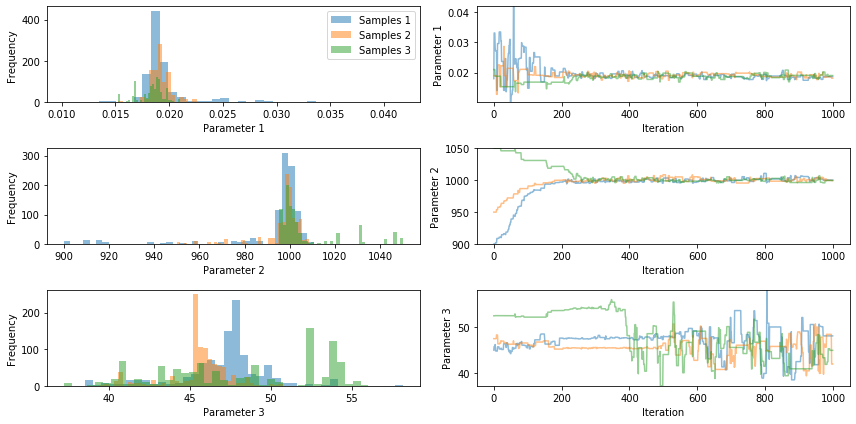

In [8]:
pints.plot.trace(chains[:3])
plt.show()

In [37]:
b = .05
K = 500
sigma = 50
x_0 = np.array([10.])
times = range(200) # 800
N = 500 # 200
iters = 1000 # 10000

real_birth = Event(
    rate_calculator=lambda x: max(0, x[0] * b * (1 - float(x[0])/K)),
    change_function=lambda x: [x[0] + 1]
    )
model_stochastic = StochasticModelTauLeaping(x_0, events=[real_birth], step_size=1, 
                                   R=np.array([[sigma]]))
measurements_stochastic = [model_stochastic.measure(t) for t in times]

exact_model = lambda t: K * x_0[0] / (x_0[0] + np.e**(-b*t) * (K - x_0[0]))
exact = [exact_model(t) for t in times]

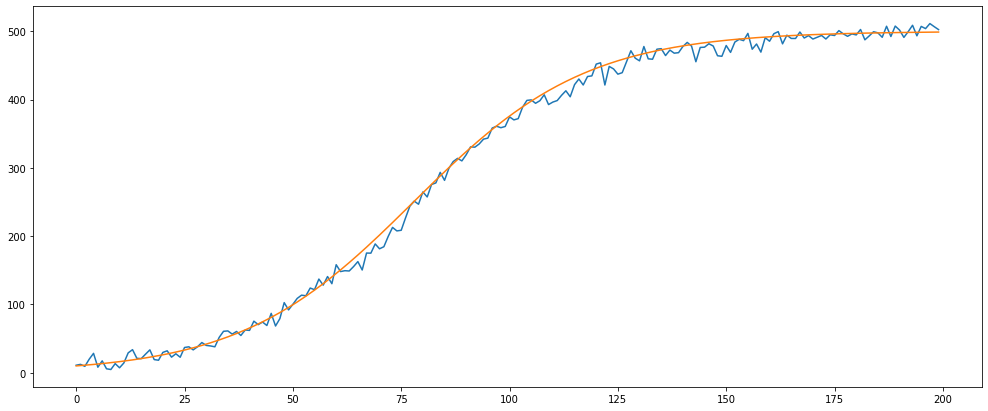

In [38]:
plt.plot(times, measurements_stochastic)
plt.plot(times, exact)